In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)

Using device: cpu


In [427]:
from typing import List, Union, Tuple

def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = np.abs(y_true - y_pred)
    naive_average_errors = np.abs(y_true - naive_forecast)

    result = np.mean(average_errors) / np.mean(naive_average_errors)
    return result


def ZBMAE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Zero-Benchmarked Mean Absolute Error (ZBMAE) между фактическими и прогнозируемыми значениями.

    ZBMAE сравнивает среднюю абсолютную ошибку прогноза с средней абсолютной ошибкой наивного прогноза, который предполагает, что все прогнозируемые значения равны нулю. Это может быть полезно для временных рядов, где ожидается, что значения будут вокруг нуля.

    Параметры:
        y_true (pd.Series): Серия с фактическими значениями.
        y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
        float: Значение ZBMAE.
    '''
    zero_forecast = 0

    average_errors = np.abs(y_true - y_pred)
    naive_average_errors = np.abs(y_true - zero_forecast)

    result = np.mean(average_errors) / np.mean(naive_average_errors.mean())
    return result

def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps) / 2
    result = (100 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result

def MDA(y_true: pd.Series, y_pred: pd.Series) -> float:

    '''
    Вычисляет Mean Directional Accuracy (MDA) между фактическими и прогнозируемыми значениями.

    MDA измеряет процент времени, когда прогноз и фактическое значение имеют одинаковое направление изменений (например, оба увеличиваются или оба уменьшаются).

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    actual_diff = np.diff(y_true)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(y_pred)
    predicted_signs = np.sign(predicted_diff)
    
    num_correct = np.sum(actual_signs == predicted_signs)
    
    mda = num_correct / (len(y_true) - 1)
    return 100*mda


def DMDA(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Direct Mean Directional Accuracy (DMDA) между фактическими и прогнозируемыми значениями.
    

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)

    result = (100 / len(y_true)) * np.sum(y_pred_sign == y_true_sign)
    return result
    

class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        data = data.sort_index()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

        self.y_val = None
        self.X_val = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame = None, date_variables: bool = False) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
            date_variables (bool): Будут ли добавлены переменные, связанные с датой.
        '''

        if other_variables is not None:
            if other_variables.isna().any().any():
                print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

            self.X = pd.concat([self.X, other_variables], axis=1, join='inner')


        if date_variables:
            self.X['days_since_start'] = (self.X.index - self.X.index[0]).days
            self.X['day'] = self.X.index.day
            self.X['dayofweek'] = self.X.index.dayofweek
            self.X['month'] = self.X.index.month
            self.X['year'] = self.X.index.year


        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(
            self, 
            horizon: int = 25, 
            num_recent_folds: int = None, 
            validation_part: float = None
            ) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
            validation_part (float): Процентное отношение объема исходных данных, отводимое для валидационного набора. Этот параметр особенно полезен в случаях, когда оптимизация гиперпараметров модели требует значительного времени. Рекомендуется однократно настроить гиперпараметры на валидационном наборе и применять их для последующих разбиений (фолдов), избегая повторного обучения на каждом фолде.
                В случае отсутствия значения параметра, валидационная часть данных не формируется.
        '''

        if validation_part is not None:
            if not 0 <= validation_part <= 1:
                raise ValueError("validation_part может быть только числом в отрезке от 0 до 1 включительно")
            
            last_val_obs = int(self.y.shape[0] * validation_part)

            self.y_val, self.y = self.y.iloc[:last_val_obs], self.y.iloc[last_val_obs:]
            self.X_val, self.X = self.X.iloc[:last_val_obs, :], self.X.iloc[last_val_obs:, :]

        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)
        self.mda = MDA(self.y_true, self.y_pred)
        self.dmda = DMDA(self.y_true, self.y_pred)
        self.zbmae = ZBMAE(self.y_true, self.y_pred)
        self.mae = mean_absolute_error(self.y_true, self.y_pred)

        print(f'MAE: {self.mae:.2f}')
        print(f'MASE: {self.mase:.2f}')
        print(f'ZBMAE: {self.zbmae:.2f}')
        print(f'SMAPE: {self.smape:.2f}%')
        print(f'MDA: {self.mda:.2f}%')
        print(f'DMDA: {self.dmda:.2f}%')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

In [428]:
data = pd.read_csv('data/data_indexes_moex_log_returns.csv', index_col=0)

In [429]:
ts = TimeSeriesProcessor(data.MOEXTL)

Новый тип индексов: pd.DatetimeIndex


In [430]:
ts.add_lags(lags=list(range(21, 148)))

In [431]:
ts.add_other_variables(date_variables=True)

In [432]:
ts.get_folds(horizon=20, num_recent_folds=5)

In [433]:
def train_and_evaluate(train_loader, X_test, model, optimizer, criterion, n_epochs=5):
    
    for epoch in range(n_epochs):
        model.train()
        for x_train, y_train in train_loader:
            y_pred = model(x_train)
            loss = criterion(y_train.view(-1, 1), y_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    model.eval()

    y_pred = model(X_test).squeeze().detach().numpy()

    return y_pred
    

class Dataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]


class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        
        self.fc_1 = nn.Linear(132, 36) 
        self.batch_norm1 = nn.BatchNorm1d(8)
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc_2 = nn.Linear(36, 8)
        self.batch_norm2 = nn.BatchNorm1d(8)
        # self.dropout2 = nn.Dropout(0.1)
        
        self.fc_3 = nn.Linear(8, 16)
        self.fc_4 = nn.Linear(16, 4)
        self.fc_5 = nn.Linear(4, 8)
        self.fc_6 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc_1(x))
        x = F.leaky_relu(self.fc_2(x))
        x = F.leaky_relu(self.fc_3(x))
        x = F.leaky_relu(self.fc_4(x))
        x = F.leaky_relu(self.fc_5(x))
        x = self.fc_6(x)

        return x



improved_model = ImprovedModel()

optimizer = torch.optim.Adam(improved_model.parameters())

criterion = nn.HuberLoss()

y_pred_list = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):  # tqdm чтобы визуализировать загрузку

    X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

    train = Dataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

    y_pred = train_and_evaluate(train_loader, X_test_tensor, improved_model, optimizer, criterion, n_epochs=6)

    y_pred = pd.Series(
        y_pred,
        index=X_test.index
    )

    y_pred_list.append(y_pred) 

ts.get_model_result(y_pred_list) 

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]

MAE: 0.01
MASE: 0.80
ZBMAE: 1.04
SMAPE: 161.72%
MDA: 49.49%
DMDA: 52.00%


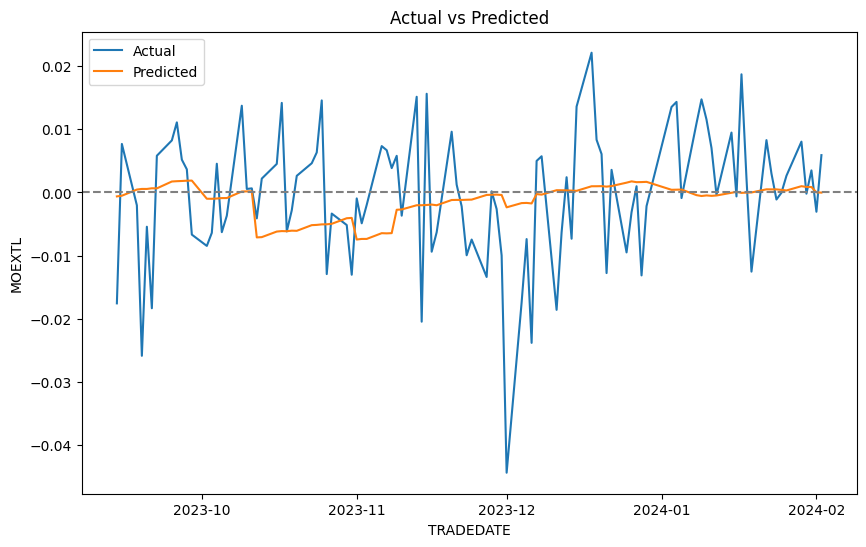

In [434]:
ts.get_visualisation()